In [131]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler # normalize data 
from keras.callbacks import ModelCheckpoint # save the best model trained 
from tensorflow.keras.models import load_model 
from keras.models import Sequential # input  
from keras.layers import LSTM 
from keras.layers import Dropout # avoid unactively learning 
from keras.layers import Dense # output 

from sklearn.metrics import r2_score 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error 

In [132]:
df=pd.read_csv("./data/retail_store_inventory.csv")
df = df[df['Category'] == 'Clothing']
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
11,2022-01-01,S001,P0012,Clothing,West,66,24,70,26.75,58.25,20,Snowy,0,62.21,Spring
13,2022-01-01,S001,P0014,Clothing,West,193,12,187,6.80,78.11,0,Sunny,0,80.06,Spring
14,2022-01-01,S001,P0015,Clothing,North,379,369,154,363.46,92.99,15,Snowy,0,95.80,Winter
17,2022-01-01,S001,P0018,Clothing,South,241,151,47,147.27,19.57,5,Cloudy,0,23.13,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73068,2024-01-01,S004,P0009,Clothing,East,115,47,139,66.94,48.65,10,Snowy,0,49.74,Winter
73071,2024-01-01,S004,P0012,Clothing,East,85,63,36,63.69,11.65,5,Rainy,0,7.14,Summer
73075,2024-01-01,S004,P0016,Clothing,West,314,182,148,193.14,19.12,0,Rainy,0,20.11,Winter
73078,2024-01-01,S004,P0019,Clothing,East,65,44,166,43.07,61.04,0,Snowy,0,60.99,Summer


In [133]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14626 entries, 7 to 73097
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                14626 non-null  datetime64[ns]
 1   Store ID            14626 non-null  object        
 2   Product ID          14626 non-null  object        
 3   Category            14626 non-null  object        
 4   Region              14626 non-null  object        
 5   Inventory Level     14626 non-null  int64         
 6   Units Sold          14626 non-null  int64         
 7   Units Ordered       14626 non-null  int64         
 8   Demand Forecast     14626 non-null  float64       
 9   Price               14626 non-null  float64       
 10  Discount            14626 non-null  int64         
 11  Weather Condition   14626 non-null  object        
 12  Holiday/Promotion   14626 non-null  int64         
 13  Competitor Pricing  14626 non-null  float64       


In [135]:
df_product_01 = df[df['Product ID'] == 'P0001']
df_product_01 = df_product_01.groupby(pd.Grouper(key='Date', freq='D'))['Units Sold'].sum()
df_product_01 = df_product_01[df_product_01 > 0]
df_product_01 = df_product_01.to_frame()
df_product_01 

,Units Sold
Date,
2022-01-03,100
2022-01-04,83
2022-01-06,195
2022-01-07,39
2022-01-08,287
...,...
2023-12-24,183
2023-12-25,49
2023-12-29,141


In [136]:
df_product_01 = df_product_01.reset_index()

In [137]:
df_product_01.columns 

Index(['Date', 'Units Sold'], dtype='object')

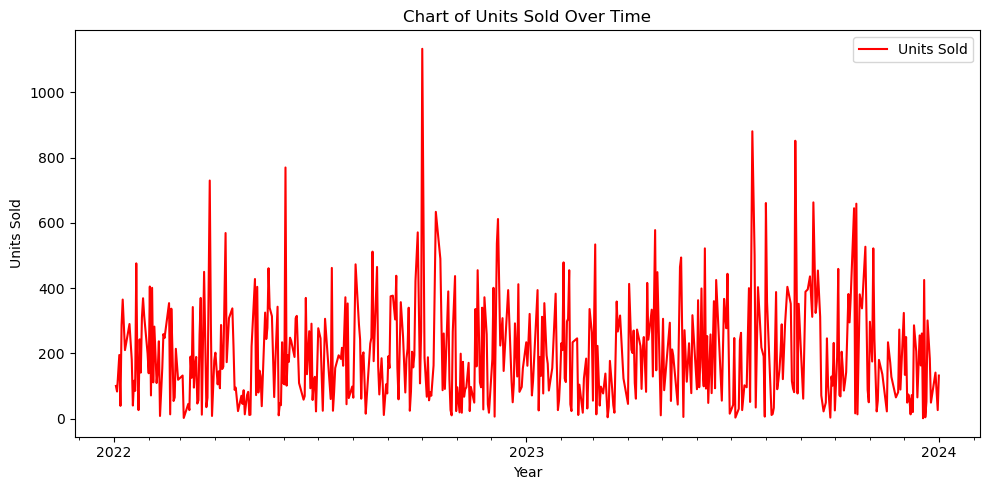

In [138]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator 
df_product_01 = df_product_01.sort_values(by='Date') 
# Get year from df_product_01['year']
# df_product_01['Year'] = df_product_01['Date'].dt.year
df_product_01 
plt.figure(figsize=(10,5)) 
plt.plot(df_product_01['Date'], df_product_01['Units Sold'], label='Units Sold', color='red')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.title('Chart of Units Sold Over Time')
plt.legend(loc='best') 
# Định dạng đồ thị hiển thị các ngày theo năm tháng 
years = YearLocator() 
yearsFmt = DateFormatter('%Y') 
months = MonthLocator() # Thêm dòng này để khai báo MonthLocator 
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)
plt.tight_layout() 
plt.show() 

In [139]:
df_product_01.index = df_product_01['Date']
df_product_01.drop('Date', axis=1, inplace=True)
df_product_01 

,Units Sold
Date,
2022-01-03,100
2022-01-04,83
2022-01-06,195
2022-01-07,39
2022-01-08,287
...,...
2023-12-24,183
2023-12-25,49
2023-12-29,141


In [140]:
data = df_product_01.values 

In [141]:
train_data = data[:400]
test_data = data[400:]
train_data

array([[ 100],
       [  83],
       [ 195],
       [  39],
       [ 287],
       [ 365],
       [ 210],
       [ 290],
       [ 181],
       [  40],
       [ 116],
       [  85],
       [ 476],
       [ 155],
       [  26],
       [ 243],
       [ 141],
       [ 310],
       [ 369],
       [ 315],
       [ 200],
       [ 139],
       [ 405],
       [  71],
       [ 401],
       [ 111],
       [ 282],
       [ 109],
       [ 150],
       [ 237],
       [   8],
       [ 154],
       [ 259],
       [ 247],
       [ 354],
       [  13],
       [ 337],
       [ 209],
       [  54],
       [  65],
       [ 214],
       [ 119],
       [ 132],
       [   2],
       [  45],
       [  26],
       [ 190],
       [ 125],
       [ 342],
       [  95],
       [ 161],
       [ 189],
       [  46],
       [  56],
       [ 258],
       [ 370],
       [  12],
       [ 450],
       [  35],
       [  64],
       [ 730],
       [ 289],
       [   8],
       [ 178],
       [ 202],
       [ 105],
       [ 1

In [142]:
test_data

array([[388],
       [ 90],
       [116],
       [150],
       [206],
       [289],
       [121],
       [293],
       [404],
       [352],
       [115],
       [ 92],
       [ 81],
       [852],
       [501],
       [ 77],
       [352],
       [ 61],
       [389],
       [396],
       [436],
       [312],
       [663],
       [324],
       [359],
       [454],
       [312],
       [ 71],
       [ 22],
       [ 49],
       [246],
       [102],
       [  3],
       [129],
       [101],
       [232],
       [ 25],
       [189],
       [459],
       [ 72],
       [ 68],
       [205],
       [155],
       [ 86],
       [112],
       [142],
       [382],
       [295],
       [369],
       [645],
       [ 16],
       [659],
       [ 13],
       [381],
       [338],
       [527],
       [ 88],
       [ 50],
       [297],
       [175],
       [522],
       [244],
       [ 22],
       [ 55],
       [180],
       [136],
       [ 22],
       [234],
       [171],
       [128],
       [ 65],
      

In [143]:
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [144]:
x_train, y_train = [], [] 
for i in range(50, len(train_data)): 
  x_train.append(sc_train[i-50:i, 0]) # lấy 50 giá trị đóng cửa liên tục 
  y_train.append(sc_train[i,0]) # lấy ra giá đóng cửa ngày hôm sau 

In [145]:
x_train

[array([0.08737864, 0.07237423, 0.17122683, 0.03353928, 0.25242718,
        0.32127096, 0.18446602, 0.25507502, 0.15887026, 0.03442189,
        0.10150044, 0.07413945, 0.41924095, 0.13592233, 0.02206531,
        0.21359223, 0.12356575, 0.27272727, 0.32480141, 0.27714034,
        0.17563989, 0.12180053, 0.35657546, 0.06178288, 0.35304501,
        0.09708738, 0.24801412, 0.09532215, 0.13150927, 0.20829656,
        0.00617829, 0.13503972, 0.22771403, 0.21712268, 0.31156222,
        0.01059135, 0.29655781, 0.18358341, 0.04677846, 0.0564872 ,
        0.18799647, 0.10414828, 0.11562224, 0.00088261, 0.03883495,
        0.02206531, 0.16681377, 0.10944395, 0.30097087, 0.08296558]),
 array([0.07237423, 0.17122683, 0.03353928, 0.25242718, 0.32127096,
        0.18446602, 0.25507502, 0.15887026, 0.03442189, 0.10150044,
        0.07413945, 0.41924095, 0.13592233, 0.02206531, 0.21359223,
        0.12356575, 0.27272727, 0.32480141, 0.27714034, 0.17563989,
        0.12180053, 0.35657546, 0.06178288, 0.

In [146]:
y_train

[0.14121800529567521,
 0.16593115622241839,
 0.03971756398940865,
 0.04854368932038835,
 0.2268314210061783,
 0.32568402471315094,
 0.00970873786407767,
 0.39629302736098854,
 0.03000882612533098,
 0.05560458958517211,
 0.6434245366284201,
 0.2541924095322154,
 0.00617828773168579,
 0.1562224183583407,
 0.177405119152692,
 0.09179170344218888,
 0.1270962047661077,
 0.08120035304501323,
 0.2524271844660194,
 0.1332744924977935,
 0.13945278022947927,
 0.501323918799647,
 0.15180935569285087,
 0.2091791703442189,
 0.2709620476610768,
 0.2974404236540159,
 0.19682259488084733,
 0.07678729037952339,
 0.08296557811120918,
 0.01941747572815534,
 0.06090026478375993,
 0.038834951456310676,
 0.07590467784642542,
 0.01059135039717564,
 0.06266548984995587,
 0.07149161518093557,
 0.008826125330979701,
 0.00970873786407767,
 0.19417475728155342,
 0.3768755516328332,
 0.06266548984995587,
 0.35569285083848196,
 0.06972639011473963,
 0.12886142983230364,
 0.11385701676963814,
 0.03265666372462489,
 

In [147]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0], 1)) 

In [148]:
model = Sequential() 
model.add(LSTM(units=120, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # eliminate some record to avoid unactively learning (overfitting) 
model.add(Dense(1)) 
model.compile(loss='mean_absolute_error', optimizer='adam')

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [149]:
save_model = "./model/lstm_model.keras" 
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=1000, batch_size=50, verbose=2, callbacks=[best_model]) 

Epoch 1/1000

Epoch 1: loss improved from inf to 0.12892, saving model to ./model/lstm_model.keras
7/7 - 3s - 429ms/step - loss: 0.1289
Epoch 2/1000

Epoch 2: loss improved from 0.12892 to 0.11732, saving model to ./model/lstm_model.keras
7/7 - 0s - 31ms/step - loss: 0.1173
Epoch 3/1000

Epoch 3: loss improved from 0.11732 to 0.11149, saving model to ./model/lstm_model.keras
7/7 - 0s - 33ms/step - loss: 0.1115
Epoch 4/1000

Epoch 4: loss did not improve from 0.11149
7/7 - 0s - 29ms/step - loss: 0.1122
Epoch 5/1000

Epoch 5: loss did not improve from 0.11149
7/7 - 0s - 27ms/step - loss: 0.1118
Epoch 6/1000

Epoch 6: loss improved from 0.11149 to 0.11124, saving model to ./model/lstm_model.keras
7/7 - 0s - 31ms/step - loss: 0.1112
Epoch 7/1000

Epoch 7: loss improved from 0.11124 to 0.10850, saving model to ./model/lstm_model.keras
7/7 - 0s - 34ms/step - loss: 0.1085
Epoch 8/1000

Epoch 8: loss did not improve from 0.10850
7/7 - 0s - 27ms/step - loss: 0.1136
Epoch 9/1000

Epoch 9: loss d

In [150]:
y_train = sc.inverse_transform(y_train)
final_model = load_model("./model/lstm_model.keras")
y_train_predict = final_model.predict(x_train) 
y_train_predict = sc.inverse_transform(y_train_predict)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [151]:
test = df_product_01[len(train_data)-50:].values 
test = test.reshape(-1,1) 
sc_test = sc.transform(test)
x_test = [] 
for i in range(50, test.shape[0]): 
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

y_test = data[80:] 
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [152]:
y_test_predict

array([[343.2779   ],
       [428.76126  ],
       [670.75146  ],
       [616.8704   ],
       [367.93307  ],
       [163.17767  ],
       [144.79819  ],
       [297.8071   ],
       [174.86232  ],
       [139.00345  ],
       [222.8594   ],
       [423.28098  ],
       [279.30167  ],
       [335.84412  ],
       [ 62.599503 ],
       [-18.270916 ],
       [ 56.504272 ],
       [ 83.56976  ],
       [152.22871  ],
       [ 48.487633 ],
       [  2.963326 ],
       [ -1.0245943],
       [  6.66567  ],
       [ 56.215023 ],
       [ 70.249435 ],
       [ 81.16417  ],
       [ 92.70889  ],
       [205.65169  ],
       [213.52095  ],
       [ 19.263506 ],
       [ 55.41497  ],
       [182.50462  ],
       [692.25104  ],
       [765.60956  ],
       [572.2055   ],
       [377.9669   ],
       [136.51434  ],
       [176.44609  ],
       [ 97.95024  ],
       [ 14.391    ],
       [167.54369  ],
       [263.68253  ],
       [111.67812  ],
       [ 82.99658  ],
       [104.0578   ],
       [19

In [153]:
y_test_predict.shape

(99, 1)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31884\3365658127.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31884\3365658127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict


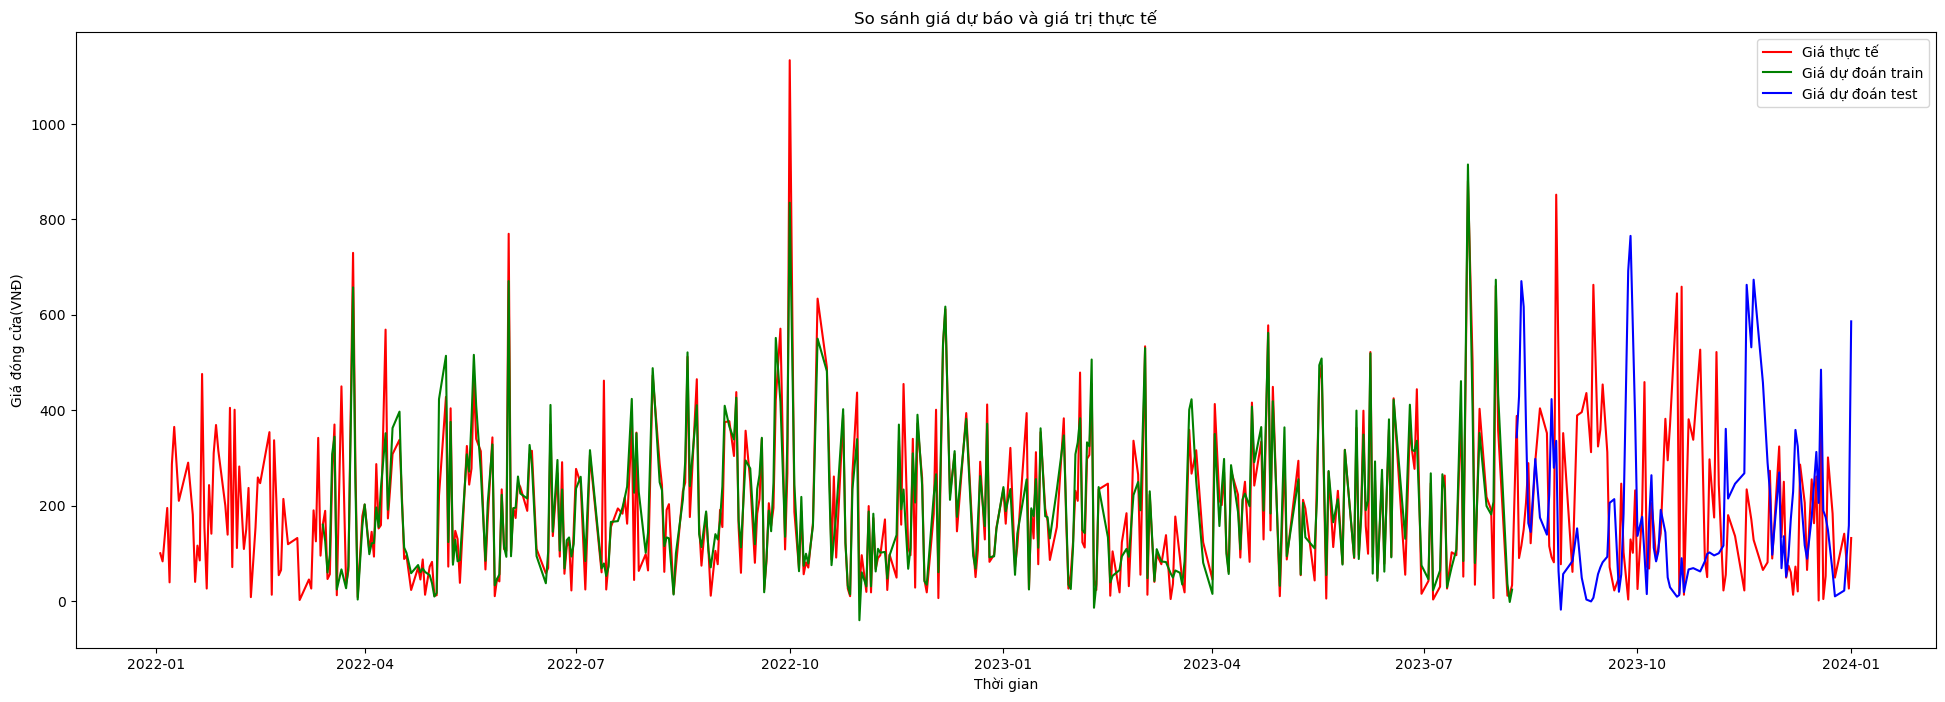

In [154]:
train_data1 = df_product_01[50:400]
test_data1 = df_product_01[400:] 
plt.figure(figsize=(24,8))
plt.plot(df_product_01, label='Giá thực tế', color='red')
train_data1['Dự đoán'] = y_train_predict 
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
test_data1['Dự đoán'] = y_test_predict 
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá trị thực tế') 
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa(VNĐ)')
plt.legend() 
plt.show() 